# CNN/DailyMail 데이터셋

In [1]:
from datasets import load_dataset

# dataset = load_dataset('cnn_dailymail', version='3.0.0')
# print(f"특성 : {dataset['train'].column_names}")

# dataset = load_dataset("cnn_dailymail", "3.0.0", split=None)
dataset = load_dataset("cnn_dailymail", "3.0.0", ignore_verifications=True)
# print(f"특성 : {dataset['train'].column_names}")

C:\Users\restful3\anaconda3\envs\trading\Lib\site-packages\datasets\load.py:2524: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [2]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


# 텍스트 요약 파이프라인

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [4]:
dataset["train"].shape

(287113, 3)

In [5]:
dataset["train"][1]

{'article': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less li

In [6]:
sample_text = dataset["train"][1]["article"][:2000]
len(sample_text)

2000

In [7]:
sample_text

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to foll

In [8]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\restful3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S are a country.', 'The U.N. is an organization.']

## 요약 기준 모델

In [9]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])
summaries = {}
summaries['baseline'] = three_sentence_summary(sample_text)

In [10]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'}

## GPT-2

In [11]:
import torch

torch.cuda.is_available()

True

In [12]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries['gpt2'] = '\n'.join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query):]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [13]:
summaries

{'baseline': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."',
 'gpt2': "To get to the jail, you go up a flight of stairs, pass a metal detector, and go down a hall.\nThe inmates are so scared that they'll be thrown in jail for not turning up your appointment.\nThe first room to the right is where the mentally ill inmates are housed, and the next room to the bottom is where the regular inmates go.\nAt the end,"}

## T5

In [14]:
pipe = pipeline("summarization", model='t5-large')
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [15]:
summaries["t5"]

'mentally ill inmates are housed on the ninth floor of a florida jail .\nmost face drug charges or charges of assaulting an officer .\njudge says arrests often result from confrontations with police .\none-third of all people in Miami-dade county jails are mental ill .'

## BART

In [16]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries['bart'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

## PEGASUS

In [18]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries['pegasus'] = pipe_out[0]['summary_text'].replace(" .<n>", ".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 요약 결과 비교하기

In [19]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2
To get to the jail, you go up a flight of stairs, pass a metal detector, and go down a hall.
The inmates are so scared that they'll be thrown in jail for not turning up your appointment.
The first room to the right is 

# 생성된 텍스트 품질 평가하기

## BLEU

In [21]:
from datasets import load_metric

bleu_metric = load_metric('sacrebleu')

C:\Users\restful3\anaconda3\envs\trading\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [22]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [23]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


## ROUGE

In [27]:
#pip install absl-py rouge-score

In [28]:
rouge_metric = load_metric("rouge")

C:\Users\restful3\anaconda3\envs\trading\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [29]:
reference = dataset['train'][1]['highlights']
records = []
rouge_names = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
    
pd.DataFrame.from_records(records, index = summaries.keys())    

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.271186,0.051724,0.152542,0.271186
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


# PEGASUS 평가

In [30]:
def evaluate_summaries_baseline(dataset, metric,
                               column_text='article', 
                               column_summary='highlights'):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

In [31]:
test_sampled = dataset['test'].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)

In [32]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient='index', columns=['baseline']).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [35]:
from tqdm import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i: i+batch_size]
        
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                              batch_size=16, device=device, 
                              column_text='article',
                              column_summary='highlights'):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding='max_length', return_tensors='pt')
        summaries = model.generate(input_ids=inputs['input_ids'].to(device),
                                  attention_mask=inputs['attention_mask'].to(device),
                                  length_penalty=0.8, num_beams=8, max_length=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [38]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = 'google/pegasus-cnn_dailymail'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                  model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [09:21<00:00,  4.49s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.434759,0.216742,0.312271,0.374631


# 요약 모델 훈련하기

In [41]:
dataset_samsum = load_dataset('samsum')
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


## SAMSum에서 PEGASUS 평가하기

In [42]:
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [43]:
score = evaluate_summaries_pegasus(dataset_samsum['test'], rouge_metric, 
                                  model, tokenizer, column_text='dialogue',
                                  column_summary='summary', batch_size=8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=['pegasus'])

100%|████████████████████████████████████████████████████████████████████████████████| 103/103 [06:35<00:00,  3.84s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296091,0.087493,0.229237,0.229642


## PEGASUS 미세 튜닝

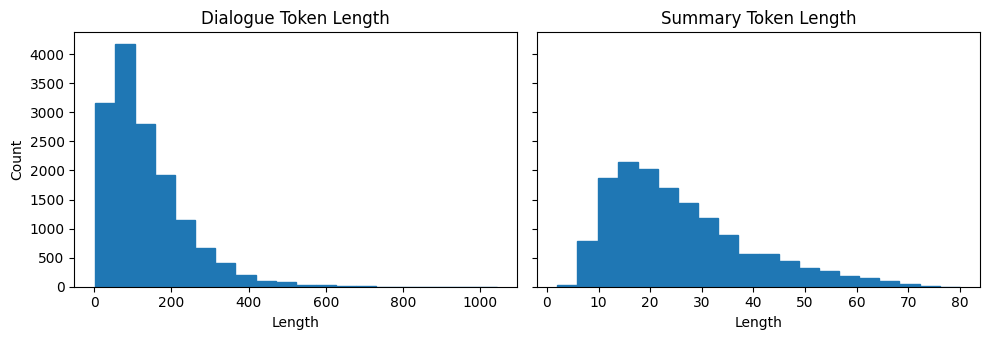

In [45]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['dialogue']]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum['train']['summary']]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [46]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    # with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(text_target=example_batch["summary"], max_length=128,
                                    truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [47]:
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [48]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [49]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=False,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [50]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [62]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.512300,1.407261


TrainOutput(global_step=920, training_loss=1.5054824829101563, metrics={'train_runtime': 1702.8826, 'train_samples_per_second': 8.651, 'train_steps_per_second': 0.54, 'total_flos': 5528248038285312.0, 'train_loss': 1.5054824829101563, 'epoch': 1.0})

In [63]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [07:35<00:00,  1.11s/it]


In [68]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

In [69]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.430549,0.199202,0.342983,0.343125


## 대화 요약 생성하기

In [70]:
import transformers
transformers.logging.set_verbosity_error()

In [73]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model=trainer.model, tokenizer=tokenizer)

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참조 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

모델 요약:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. He's nice. Hannah will text Betty.


In [74]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis, Leandro and Leandro are going to write a book about transformers by Hugging. Face. Thom, Lewis and Leandro are going to do it together.
